# JaX Flax --> ONNX

This notebook converts brax MLP networks to an ONNX checkpoint.

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
from brax.training.agents.ppo import networks as ppo_networks
from mujoco_playground.config import locomotion_params, manipulation_params
from mujoco_playground import locomotion, manipulation
import functools
import pickle
import jax.numpy as jp
import jax
import tf2onnx
import tensorflow as tf
from tensorflow.keras import layers
import onnxruntime as rt
from brax.training.acme import running_statistics
from brax.training.checkpoint import load
from etils import epath

In [3]:
env_name = "Go2FlipRL"
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [4]:
def identity_observation_preprocessor(observation, preprocessor_params):
  del preprocessor_params
  return observation

network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

In [5]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)

ERROR:2025-09-13 14:54:34,354:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/yilang/miniforge3/envs/playground/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/yilang/miniforge3/envs/playground/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/yilang/miniforge3/envs/playground/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_

In [6]:
obs_size = env.observation_size
act_size = env.action_size
print(obs_size, act_size)

{'privileged_state': (91,), 'state': (42,)} 12


In [7]:
ppo_network = network_factory(obs_size, act_size)

In [ ]:
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2JoystickFlatTerrain-20250909-145638/checkpoints/200540160"
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2JoystickFlatTerrain-20250909-202242/checkpoints/200540160"
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2JoystickFlatTerrainNoLinVel/checkpoints/200540160"
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2Footstand-no-lin-vel-fine-tune/checkpoints/150077440"
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2Footstand-20250912-152757/checkpoints/150077440"
# ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2FlipRL-no-lin-good/checkpoints/150077440"
ckpt_path = "/home/yilang/research/Go2BraxDeploy/mujoco_playground/logs/Go2Footstand-no-lin-vel-action/checkpoints/150077440"

params = load(ckpt_path)

output_path = f"bh_policy.onnx"

In [9]:
make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params, deterministic=True)

In [10]:
class MLP(tf.keras.Model):
    def __init__(
        self,
        layer_sizes,
        activation=tf.nn.relu,
        kernel_init="lecun_uniform",
        activate_final=False,
        bias=True,
        layer_norm=False,
        mean_std=None,
    ):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.activation = activation
        self.kernel_init = kernel_init
        self.activate_final = activate_final
        self.bias = bias
        self.layer_norm = layer_norm

        if mean_std is not None:
            self.mean = tf.Variable(mean_std[0], trainable=False, dtype=tf.float32)
            self.std = tf.Variable(mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.mean = None
            self.std = None

        self.mlp_block = tf.keras.Sequential(name="MLP_0")
        for i, size in enumerate(self.layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.mlp_block.add(dense_layer)
            if self.layer_norm:
                self.mlp_block.add(layers.LayerNormalization(name=f"layer_norm_{i}"))
        if not self.activate_final and self.mlp_block.layers:
            if hasattr(self.mlp_block.layers[-1], 'activation') and self.mlp_block.layers[-1].activation is not None:
                self.mlp_block.layers[-1].activation = None

        self.submodules = [self.mlp_block]

    def call(self, inputs):
        if isinstance(inputs, list):
            inputs = inputs[0]
        if self.mean is not None and self.std is not None:
            print(self.mean.shape, self.std.shape)
            inputs = (inputs - self.mean) / self.std
        logits = self.mlp_block(inputs)
        loc, _ = tf.split(logits, 2, axis=-1)
        return tf.tanh(loc)

def make_policy_network(
    param_size,
    mean_std,
    hidden_layer_sizes=[256, 256],
    activation=tf.nn.relu,
    kernel_init="lecun_uniform",
    layer_norm=False,
):
    policy_network = MLP(
        layer_sizes=list(hidden_layer_sizes) + [param_size],
        activation=activation,
        kernel_init=kernel_init,
        layer_norm=layer_norm,
        mean_std=mean_std,
    )
    return policy_network

In [11]:
mean = params[0].mean["state"]
std = params[0].std["state"]

# Convert mean/std jax arrays to tf tensors.
mean_std = (tf.convert_to_tensor(mean), tf.convert_to_tensor(std))

tf_policy_network = make_policy_network(
    param_size=act_size * 2,
    mean_std=mean_std,
    hidden_layer_sizes=ppo_params.network_factory.policy_hidden_layer_sizes,
    activation=tf.nn.swish,
)


2025-09-13 14:54:35.902020: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [12]:
example_input = tf.zeros((1, obs_size["state"][0]))
example_output = tf_policy_network(example_input)
print(example_output.shape)

(42,) (42,)
(42,) (42,)
(1, 12)


In [13]:
import numpy as np
import tensorflow as tf

def transfer_weights(jax_params, tf_model):
    """
    Transfer weights from a JAX parameter dictionary to the TensorFlow model.

    Parameters:
    - jax_params: dict
      Nested dictionary with structure {block_name: {layer_name: {params}}}.
      For example:
      {
        'CNN_0': {
          'Conv_0': {'kernel': np.ndarray},
          'Conv_1': {'kernel': np.ndarray},
          'Conv_2': {'kernel': np.ndarray},
        },
        'MLP_0': {
          'hidden_0': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_1': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_2': {'kernel': np.ndarray, 'bias': np.ndarray},
        }
      }

    - tf_model: tf.keras.Model
      An instance of the adapted VisionMLP model containing named submodules and layers.
    """
    for layer_name, layer_params in jax_params.items():
        try:
            tf_layer = tf_model.get_layer("MLP_0").get_layer(name=layer_name)
        except ValueError:
            print(f"Layer {layer_name} not found in TensorFlow model.")
            continue
        if isinstance(tf_layer, tf.keras.layers.Dense):
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            print(f"Transferring Dense layer {layer_name}, kernel shape {kernel.shape}, bias shape {bias.shape}")
            tf_layer.set_weights([kernel, bias])
        else:
            print(f"Unhandled layer type in {layer_name}: {type(tf_layer)}")

    print("Weights transferred successfully.")

In [14]:
transfer_weights(params[1]['params'], tf_policy_network)

Transferring Dense layer hidden_0, kernel shape (42, 512), bias shape (512,)
Transferring Dense layer hidden_1, kernel shape (512, 256), bias shape (256,)
Transferring Dense layer hidden_2, kernel shape (256, 128), bias shape (128,)
Transferring Dense layer hidden_3, kernel shape (128, 24), bias shape (24,)
Weights transferred successfully.


In [15]:
# Example inputs for the model
test_input = [np.ones((1, obs_size["state"][0]), dtype=np.float32)]

# Define the TensorFlow input signature
spec = [tf.TensorSpec(shape=(1, obs_size["state"][0]), dtype=tf.float32, name="obs")]

tensorflow_pred = tf_policy_network(test_input)[0]
# Build the model by calling it with example data
print(f"Tensorflow prediction: {tensorflow_pred}")

tf_policy_network.output_names = ['continuous_actions']

# opset 11 matches isaac lab.
model_proto, _ = tf2onnx.convert.from_keras(tf_policy_network, input_signature=spec, opset=11, output_path=output_path)

# Run inference with ONNX Runtime
output_names = ['continuous_actions']
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

I0000 00:00:1757789676.104418  120949 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1757789676.104557  120949 single_machine.cc:376] Starting new session
I0000 00:00:1757789676.130110  120949 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1757789676.130204  120949 single_machine.cc:376] Starting new session
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x715b01654d60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


(42,) (42,)
Tensorflow prediction: [ 0.97601885 -0.82674265 -0.45084623  0.8532765   0.791123    0.9942376
  0.9237942   0.28034055 -0.9875181   0.53453994  0.90735954 -0.9542331 ]
(42,) (42,)


In [16]:
onnx_input = {
  'obs': np.ones((1, obs_size["state"][0]), dtype=np.float32)
}
# Prepare inputs for ONNX Runtime
onnx_pred = m.run(output_names, onnx_input)[0][0]

print("ONNX prediction:", onnx_pred)

ONNX prediction: [ 0.9760188  -0.82674307 -0.45084676  0.8532766   0.791123    0.9942378
  0.92379415  0.28034    -0.9875179   0.5345409   0.9073593  -0.95423317]


In [17]:
test_input = {
    'state': jp.ones(obs_size["state"]),
    'privileged_state': jp.zeros(obs_size["privileged_state"])
}
jax_pred, _ = inference_fn(test_input, jax.random.PRNGKey(0))
print(jax_pred)

[ 0.9760189  -0.8267429  -0.45084652  0.85327667  0.79112285  0.9942378
  0.92379415  0.28034028 -0.9875179   0.53453976  0.9073596  -0.95423305]


(12,)
(12,)
(12,)


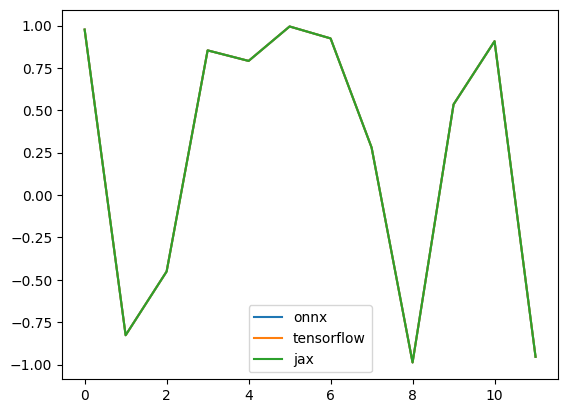

In [18]:
import matplotlib.pyplot as plt
print(onnx_pred.shape)
print(tensorflow_pred.shape)
print(jax_pred.shape)
plt.plot(onnx_pred, label='onnx')
plt.plot(tensorflow_pred, label='tensorflow')
plt.plot(jax_pred, label='jax')
plt.legend()
plt.show()

In [19]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

In [20]:
# # Test the policy.

# # env_cfg = locomotion.get_default_config(env_name)
# # env_cfg.init_from_crouch = 0.0
# # env = locomotion.load(env_name, config=env_cfg)
# # env_cfg = manipulation.get_default_config(env_name)
# # env = manipulation.load(env_name, config=env_cfg)
# # jit_reset = jax.jit(env.reset)
# # jit_step = jax.jit(env.step)

# x = 0.8
# y = 0.0
# yaw = 0.3
# command = jp.array([x, y, yaw])
# # actions = []

# states = [state := jit_reset(jax.random.PRNGKey(555))]
# state.info["command"] = command
# for _ in range(env_cfg.episode_length):
#   onnx_input = {'obs': np.array(state.obs["state"].reshape(1, -1))}
#   action = m.run(output_names, onnx_input)[0][0]
#   state = jit_step(state, jp.array(action))
#   state.info["command"] = command
#   states.append(state)
#   # actions.append(state.info["motor_targets"])
#   # actions.append(action)
#   if state.done:
#     print("Unexpected termination.")
#     break

In [21]:
# import mediapy as media
# fps = 1.0 / env.dt

# frames = env.render(
#     states,
#     camera="track",
#     width=640*2,
#     height=480*2,
# )
# media.show_video(frames, fps=fps, loop=False)